# Práctico 2: Recomendación de videojuegos
<h3><FONT COLOR="#FF0000"> Alumno: Zoppini Maximo (Omega)</FONT></h3>


En este práctico trabajaremos con un subconjunto de datos sobre [videojuegos de Steam](http://cseweb.ucsd.edu/~jmcauley/datasets.html#steam_data). Para facilitar un poco el práctico, se les dará el conjunto de datos previamente procesado. En este mismo notebook mostraremos el proceso de limpieza, para que quede registro del proceso (de todas maneras, por el tamaño de los datos no recomendamos que pierdan tiempo en el proceso salvo que lo consideren útil a fines personales). 

El conjunto de datos se basa en dos partes: lista de juegos (items), y lista de reviews de usuarios sobre distintos juegos. Este último, en su versión original es muy grande, (pesa 1.3GB), por lo que será solo una muestra del mismo sobre la que trabajarán.

A diferencia del conjunto de datos de LastFM utilizados en el [Práctico 1](./practico1.ipynb), en este caso los datos no están particularmente pensados para un sistema de recomendación, por lo que requerirá de un poco más de trabajo general sobre el dataset.

La idea es que, de manera similar al práctico anterior, realicen un sistema de recomendación. A diferencia del práctico anterior, este será un poco más completo y deberán hacer dos sistemas, uno que, dado un nombre de usuario le recomiende una lista de juegos, y otro que dado el título de un juego, recomiende una lista de juegos similares. Además, en este caso se requiere que el segundo sistema (el que recomienda juegos basado en el nombre de un juego en particular) haga uso de la información de contenido (i.e. o bien harán un filtrado basado en contenido o algo híbrido).

## Obtención y limpieza del conjunto de datos

El conjunto de datos originalmente se encuentra en archivos que deberían ser de formato "JSON". Sin embargo, en realidad es un archivo donde cada línea es un objeto de JSON. Hay un problema no obstante y es que las líneas están mal formateadas, dado que no respetan el estándar JSON de utilizar comillas dobles (**"**) y en su lugar utilizan comillas simples (**'**). Afortunadamente, se pueden evaluar como diccionarios de Python, lo cuál permite trabajarlos directamente.

### Descarga

La siguiente celda descarga los conjuntos de datos crudos. Nuevamente, no es necesario ejecutarla y pueden ir [más abajo](#Conjunto-de-datos-limpio) para ejecutar la celda que descargará el conjunto ya procesado.

In [1]:
%%bash

mkdir -p data/steam/
curl -L -o data/steam/steam_games.json.gz http://cseweb.ucsd.edu/\~wckang/steam_games.json.gz
curl -L -o data/steam/steam_reviews.json.gz http://cseweb.ucsd.edu/\~wckang/steam_reviews.json.gz

Couldn't find program: 'bash'


### Carga de datos

Como se dijo, por la naturaleza de los datos, necesitamos utilizar Python para trabajarlos (no podemos leerlos con JSON).

In [2]:
#
import gzip
from tqdm import tqdm_notebook  # To print a progress bar (comes with Anaconda or can be installed)


In [3]:
#

with gzip.open("./data/steam/steam_games.json.gz") as fh:
    games = []
    for game in tqdm_notebook(fh, total=32135):
        try:
            games.append(eval(game))
        except SyntaxError:
            continue

print("Loaded {} games".format(len(games)))



Loaded 32135 games


In [4]:
#

with gzip.open("./data/steam/steam_reviews.json.gz") as fh:
    reviews = []
    for review in tqdm_notebook(fh, total=7793069):
        try:
            reviews.append(eval(review))
        except SyntaxError:
            continue

print("Loaded {} user reviews".format(len(reviews)))



Loaded 7793069 user reviews


### Exploración de los datos

En esta parte necesitamos revisar la estructura general, para poder pasarlos a un formato más amigable (e.g. CSV).

In [5]:
games[0]

{'publisher': 'Kotoshiro',
 'genres': ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy'],
 'app_name': 'Lost Summoner Kitty',
 'title': 'Lost Summoner Kitty',
 'url': 'http://store.steampowered.com/app/761140/Lost_Summoner_Kitty/',
 'release_date': '2018-01-04',
 'tags': ['Strategy', 'Action', 'Indie', 'Casual', 'Simulation'],
 'discount_price': 4.49,
 'reviews_url': 'http://steamcommunity.com/app/761140/reviews/?browsefilter=mostrecent&p=1',
 'specs': ['Single-player'],
 'price': 4.99,
 'early_access': False,
 'id': '761140',
 'developer': 'Kotoshiro'}

In [6]:
reviews[0]

{'username': 'Chaos Syren',
 'product_id': '725280',
 'page_order': 0,
 'text': 'This would not be acceptable as an entertainment even back in the day when these graphics were all there was to be had. No effort has been made to bring the player into any story or even entertain.',
 'hours': 0.1,
 'recommended': True,
 'products': 41,
 'date': '2017-12-17',
 'early_access': False,
 'page': 1}

### Transformación de los datos

Viendo los datos que tenemos de cada tipo, podemos utilizar pandas para leer los registros y trabajar con algo más sencillo.

In [7]:
import pandas as pd

In [8]:
games = pd.DataFrame.from_records(games)
games.head(3)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN


In [9]:
reviews = pd.DataFrame.from_records(reviews)
reviews.head(3)

,username,product_id,page_order,text,hours,recommended,products,date,early_access,page,compensation,found_funny,user_id
0,Chaos Syren,725280,0,This would not be acceptable as an entertainme...,0.1,True,41.0,2017-12-17,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,328100,0,looks like a facebook game,51.1,True,769.0,2017-12-27,False,1,NaN,NaN,NaN
2,hello?<,328100,1,Better than Minecraft,14.6,True,2.0,2017-10-16,False,1,Product received for free,2.0,NaN


### Selección de características

Teniendo los datos, podemos hacer una selección muy superficial (no basada en EDA) de algunas características que consideremos irrelevantes. En particular, para el caso del dataset de juegos, vemos que las columnas `url` y `reviews_url` no son útiles a los propósitos de este práctico, por lo que las removeremos.

Por el lado del dataset de opiniones todas parecen útiles. Aunque, si vemos muy por arriba `recommended` vemos que para todos los valores son `True`, por lo que la podemos sacar también.

In [10]:
games.drop(columns=["url", "reviews_url"], inplace=True)
games.head(3)

,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,[Single-player],4.99,False,761140,Kotoshiro,NaN,NaN
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980,Secret Level SRL,Mostly Positive,NaN
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290,Poolians.com,Mostly Positive,NaN


In [11]:
reviews.drop(columns=["recommended"], inplace=True)
reviews.head(3)

,username,product_id,page_order,text,hours,products,date,early_access,page,compensation,found_funny,user_id
0,Chaos Syren,725280,0,This would not be acceptable as an entertainme...,0.1,41.0,2017-12-17,False,1,NaN,NaN,NaN
1,₮ʜᴇ Wᴀʀᴛᴏɴ,328100,0,looks like a facebook game,51.1,769.0,2017-12-27,False,1,NaN,NaN,NaN
2,hello?<,328100,1,Better than Minecraft,14.6,2.0,2017-10-16,False,1,Product received for free,2.0,NaN


### Muestreo y guarda de datos

Como dijimos, tenemos muchas reviews. Sería excelente trabajarlas a todas, pero el dataset es medio pesado (en RAM llega a ocupar más de 8 GB). Por lo que optaremos por hacer un muestreo de reviews. Esto quiere decir que, probablemente, algunos usuarios/juegos queden afuera. Podríamos hacer algún muestreo estratificado, pero iremos por algo más sencillo. Dejaremos aproximadamente el 10% del dataset (700 mil reviews).

El conjunto de datos de juegos lo dejaremos como está. Lo guardaremos con formato JSON para conservar la información de aquellas columnas que sean de tipo lista.

In [12]:
games.to_json("./data/steam/xgames.json.gz", orient="records")
reviews.sample(n=int(7e5), random_state=42).to_json("./data/steam/xreviews.json.gz", orient="records")

## Conjunto de datos limpio

Para descargar el conjunto de datos que se utilizará en el práctico, basta con ejecutar la siguiente celda.

In [1]:
%%bash

mkdir -p data/steam/
curl -L -o data/steam/games.json.gz https://cs.famaf.unc.edu.ar/\~ccardellino/diplomatura/games.json.gz
curl -L -o data/steam/reviews.json.gz https://cs.famaf.unc.edu.ar/\~ccardellino/diplomatura/reviews.json.gz

Couldn't find program: 'bash'


## Ejercicio 1: Análisis Exploratorio de Datos

Ya teniendo los datos, podemos cargarlos y empezar con el práctico. Antes que nada vamos a hacer una exploración de los datos. Lo principal a tener en cuenta para este caso es que debemos identificar las variables con las que vamos a trabajar. A diferencia del práctico anterior, este conjunto de datos no está documentado, por lo que la exploración es necesaria para poder entender que cosas van a definir nuestro sistema de recomendación.

In [2]:
import pandas as pd
import numpy as np
import random

my_seed = 42
random.seed(my_seed)
np.random.seed(my_seed)


### Características del conjunto de datos sobre videojuegos

Las características del conjunto de datos de videojuegos tienen la información necesaria para hacer el "vector de contenido" utilizado en el segundo sistema de recomendación. Su tarea es hacer un análisis sobre dicho conjunto de datos y descartar aquella información redundante.

In [3]:
#

games = pd.read_json("./data/steam/games.json.gz")
games.head()


,publisher,genres,app_name,title,release_date,tags,discount_price,specs,price,early_access,id,developer,sentiment,metascore
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",4.49,[Single-player],4.99,False,761140.0,Kotoshiro,None,None
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,None
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",NaN,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,None
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,2017-12-07,"[Action, Adventure, Casual]",0.83,[Single-player],0.99,False,767400.0,彼岸领域,None,None
4,None,None,Log Challenge,None,None,"[Action, Indie, Casual, Sports]",1.79,"[Single-player, Full controller support, HTC V...",2.99,False,773570.0,None,None,None


In [4]:
#valores NaN en games...

print(pd.concat([games.isna().sum().rename('NaN_abs'), ((games.isna().sum() / len(games)) * 100).rename('NaN_%')], axis = 1).sort_values(by = 'NaN_%', ascending = False))
print()
print('Total de registros en games: {}'.format(games.shape[0]))


                NaN_abs      NaN_%
discount_price    31910  99.299829
metascore         29458  91.669519
publisher          8052  25.056792
sentiment          7182  22.349463
developer          3299  10.266065
genres             3283  10.216275
release_date       2067   6.432239
title              2050   6.379337
price              1377   4.285047
specs               670   2.084954
tags                163   0.507235
app_name              2   0.006224
id                    2   0.006224
early_access          0   0.000000

Total de registros en games: 32135


In [5]:
#eliminamos los 2 registros NaN
games.drop(games[games['app_name'].isna()].index, inplace = True)
games.drop(games[games['id'].isna()].index, inplace = True)

games.drop(['discount_price', 'metascore', 'release_date'], axis = 1, inplace = True)

games


,publisher,genres,app_name,title,tags,specs,price,early_access,id,developer,sentiment
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,False,761140.0,Kotoshiro,None
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290.0,Poolians.com,Mostly Positive
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,"[Action, Adventure, Casual]",[Single-player],0.99,False,767400.0,彼岸领域,None
4,None,None,Log Challenge,None,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.99,False,773570.0,None,None
...,...,...,...,...,...,...,...,...,...,...,...
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,"[Strategy, Indie, Casual, Simulation]","[Single-player, Steam Achievements]",1.99,False,773640.0,"Nikita ""Ghost_RUS""",None
32131,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,"[Strategy, Indie, Casual]","[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530.0,Sacada,None
32132,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,"[Indie, Simulation, Racing]","[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660.0,Laush Dmitriy Sergeevich,None
32133,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...","[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870.0,"xropi,stev3ns",1 user reviews


In [6]:
dicc = pd.Series(np.where((games['app_name'].str.upper().str.strip() == games['title'].str.upper().str.strip()), True, False)).value_counts().to_dict()

print('Cantidad de valores True : {}'.format(dicc[True]))
print('Cantidad de valores False: {}'.format(dicc[False]))


Cantidad de valores True : 29529
Cantidad de valores False: 2603


In [7]:
games[((games['app_name'].str.upper().str.strip() != games['title'].str.upper().str.strip()) & games['title'].notna())][['app_name', 'title']]


,app_name,title
80,Sam & Max 101: Culture Shock,Sam &amp; Max 101: Culture Shock
83,Sam & Max 102: Situation: Comedy,Sam &amp; Max 102: Situation: Comedy
109,Command & Conquer: Red Alert 3,Command &amp; Conquer: Red Alert 3
182,Heroes of Might & Magic V: Hammers of Fate,Heroes of Might &amp; Magic V: Hammers of Fate
184,Heroes of Might & Magic V: Tribes of the East,Heroes of Might &amp; Magic V: Tribes of the East
...,...,...
31871,Sam & Max 105: Reality 2.0,Sam &amp; Max 105: Reality 2.0
31872,Sam & Max 104: Abe Lincoln Must Die!,Sam &amp; Max 104: Abe Lincoln Must Die!
31873,Sam & Max 106: Bright Side of the Moon,Sam &amp; Max 106: Bright Side of the Moon
31898,Making History: The Calm & the Storm,Making History: The Calm &amp; the Storm


In [8]:
#drop 'title'...

games.drop(['title'], axis = 1, inplace = True)
games


,publisher,genres,app_name,tags,specs,price,early_access,id,developer,sentiment
0,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,"[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99,False,761140.0,Kotoshiro,None
1,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,"[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive
2,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,"[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",Free to Play,False,670290.0,Poolians.com,Mostly Positive
3,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,"[Action, Adventure, Casual]",[Single-player],0.99,False,767400.0,彼岸领域,None
4,None,None,Log Challenge,"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.99,False,773570.0,None,None
...,...,...,...,...,...,...,...,...,...,...
32130,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,"[Strategy, Indie, Casual, Simulation]","[Single-player, Steam Achievements]",1.99,False,773640.0,"Nikita ""Ghost_RUS""",None
32131,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,"[Strategy, Indie, Casual]","[Single-player, Steam Achievements, Steam Clou...",4.99,False,733530.0,Sacada,None
32132,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,"[Indie, Simulation, Racing]","[Single-player, Steam Achievements, Steam Trad...",1.99,False,610660.0,Laush Dmitriy Sergeevich,None
32133,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...","[Single-player, Steam Achievements, Steam Cloud]",4.99,False,658870.0,"xropi,stev3ns",1 user reviews


In [9]:
games[games['genres'].isna()][['genres', 'tags']]


,genres,tags
4,None,"[Action, Indie, Casual, Sports]"
11,None,[Casual]
19,None,"[Early Access, Indie, VR]"
20,None,"[Early Access, Action, Adventure, Indie, Casual]"
22,None,"[Early Access, Strategy, Action, Indie, Casual..."
...,...,...
32118,None,"[Design & Illustration, Tutorial]"
32119,None,"[Design & Illustration, Tutorial]"
32120,None,[Movie]
32121,None,"[Design & Illustration, Tutorial]"


In [10]:
#drop 'tags'...

games.drop(['tags'], axis = 1, inplace = True)

#reemplazamos NaN en 'genres' por 'sindatos'.
games.fillna({'genres':'sindatos'}, inplace = True)


In [11]:
dicc = pd.Series(np.where((games['publisher'].str.upper().str.strip() == games['developer'].str.upper().str.strip()), True, False)).value_counts().to_dict()

print('Cantidad de valores True : {}'.format(dicc[True]))
print('Cantidad de valores False: {}'.format(dicc[False]))


Cantidad de valores True : 12458
Cantidad de valores False: 19674


In [12]:
games[(games['publisher'].str.upper().str.strip() != games['developer'].str.upper().str.strip())][['publisher', 'developer']]


,publisher,developer
1,"Making Fun, Inc.",Secret Level SRL
4,None,None
6,None,Poppermost Productions
11,None,None
19,None,None
...,...,...
32126,OrtiGames/OrtiSoft,"Oscar Ortigueira López,OrtiGames/OrtiSoft"
32130,Ghost_RUS Games,"Nikita ""Ghost_RUS"""
32132,Laush Studio,Laush Dmitriy Sergeevich
32133,SIXNAILS,"xropi,stev3ns"


In [13]:
#reemplazamos valores NaN.

games.fillna({'publisher':'sindatos', 'developer':'sindatos'}, inplace = True)
games.fillna({'sentiment':'sindatos', 'specs':'sindatos'}, inplace = True)


In [16]:
#reemplazamos 'price' NO Numéricos por 0...
#reemplazamos NaN por promedio.

games.loc[games['price'].str.isnumeric() == False, 'price'] = 0
games['price'].fillna(games['price'].mean(), inplace = True)

print('Cantidad de registros    NaN:', games['price'].isnull().sum())
print('Cantidad de registros NO NaN:', games['price'].notnull().sum())


Cantidad de registros    NaN: 0
Cantidad de registros NO NaN: 32132


In [17]:
games.id = games.id.astype('int64')
games.early_access = games.early_access.astype('int64')

games.dtypes


publisher        object
genres           object
app_name         object
specs            object
price           float64
early_access      int64
id                int64
developer        object
sentiment        object
dtype: object

In [18]:
print(pd.concat([games.isna().sum().rename('NaN_abs'), ((games.isna().sum() / len(games)) * 100).rename('NaN_%')], axis = 1).sort_values(by = 'NaN_%', ascending = False))
print()
print('Total de registros en games: {}'.format(games.shape[0]))


              NaN_abs  NaN_%
publisher           0    0.0
genres              0    0.0
app_name            0    0.0
specs               0    0.0
price               0    0.0
early_access        0    0.0
id                  0    0.0
developer           0    0.0
sentiment           0    0.0

Total de registros en games: 32132


In [19]:
games_reducida = games.drop(['publisher', 'app_name', 'developer', 'id'], axis = 1)
games_reducida


,genres,specs,price,early_access,sentiment
0,"[Action, Casual, Indie, Simulation, Strategy]",[Single-player],4.99,0,sindatos
1,"[Free to Play, Indie, RPG, Strategy]","[Single-player, Multi-player, Online Multi-Pla...",0.00,0,Mostly Positive
2,"[Casual, Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...",0.00,0,Mostly Positive
3,"[Action, Adventure, Casual]",[Single-player],0.99,0,sindatos
4,sindatos,"[Single-player, Full controller support, HTC V...",2.99,0,sindatos
...,...,...,...,...,...
32130,"[Casual, Indie, Simulation, Strategy]","[Single-player, Steam Achievements]",1.99,0,sindatos
32131,"[Casual, Indie, Strategy]","[Single-player, Steam Achievements, Steam Clou...",4.99,0,sindatos
32132,"[Indie, Racing, Simulation]","[Single-player, Steam Achievements, Steam Trad...",1.99,0,sindatos
32133,"[Casual, Indie]","[Single-player, Steam Achievements, Steam Cloud]",4.99,0,1 user reviews


In [20]:
#generamos dummies sobre 'genres'

genres_dummies = pd.get_dummies(games_reducida.genres.apply(pd.Series).stack()).sum(level = 0)

genres_dummies


,Accounting,Action,Adventure,Animation &amp; Modeling,Audio Production,Casual,Design &amp; Illustration,Early Access,Education,Free to Play,...,RPG,Racing,Simulation,Software Training,Sports,Strategy,Utilities,Video Production,Web Publishing,sindatos
0,0,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,1,0,0,0,1,...,0,0,1,0,1,0,0,0,0,0
3,0,1,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32130,0,0,0,0,0,1,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0
32131,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
32132,0,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,0,0,0,0,0
32133,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
#generamos dummies sobre 'specs'

specs_dummies = pd.get_dummies(games_reducida.specs.apply(pd.Series).stack()).sum(level = 0)

specs_dummies


,Captions available,Co-op,Commentary available,Cross-Platform Multiplayer,Downloadable Content,Full controller support,Game demo,Gamepad,HTC Vive,In-App Purchases,...,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Motion Controllers,Valve Anti-Cheat enabled,Windows Mixed Reality,sindatos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32130,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32131,0,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
32132,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
32133,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [22]:
#dropeamos 'genres' y 'specs'...
#dummies sobre el resto.

games_reducida.drop(['genres', 'specs'], axis = 1, inplace = True)
games_reducida = pd.get_dummies(games_reducida)
games_reducida


,price,early_access,sentiment_1 user reviews,sentiment_2 user reviews,sentiment_3 user reviews,sentiment_4 user reviews,sentiment_5 user reviews,sentiment_6 user reviews,sentiment_7 user reviews,sentiment_8 user reviews,...,sentiment_Mixed,sentiment_Mostly Negative,sentiment_Mostly Positive,sentiment_Negative,sentiment_Overwhelmingly Negative,sentiment_Overwhelmingly Positive,sentiment_Positive,sentiment_Very Negative,sentiment_Very Positive,sentiment_sindatos
0,4.99,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0.00,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.00,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,0.99,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2.99,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32130,1.99,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
32131,4.99,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
32132,1.99,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
32133,4.99,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
#merge sobre las 3...
#... creamos la games_XL.
#... y scalamos 'price'.
from sklearn.preprocessing import MinMaxScaler

games_XL = pd.concat([games_reducida, genres_dummies, specs_dummies], axis = 1)

scaler = MinMaxScaler()
games_XL[['price']] = scaler.fit_transform(games_XL[['price']])

games_XL


,price,early_access,sentiment_1 user reviews,sentiment_2 user reviews,sentiment_3 user reviews,sentiment_4 user reviews,sentiment_5 user reviews,sentiment_6 user reviews,sentiment_7 user reviews,sentiment_8 user reviews,...,Steam Cloud,Steam Leaderboards,Steam Trading Cards,Steam Turn Notifications,Steam Workshop,SteamVR Collectibles,Tracked Motion Controllers,Valve Anti-Cheat enabled,Windows Mixed Reality,sindatos
0,0.005015,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.000000,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,0.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.000995,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.003005,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32130,0.002000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
32131,0.005015,0,0,0,0,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
32132,0.002000,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
32133,0.005015,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [24]:
#valores NaN en games_XL

print(pd.concat([games_XL.isna().sum().rename('NaN_abs'), ((games_XL.isna().sum() / len(games_XL)) * 100).rename('NaN_%')], axis = 1).sort_values(by = 'NaN_%', ascending = False))
print()
print('Total de registros en games_XL: {}'.format(games_XL.shape[0]))


                           NaN_abs  NaN_%
price                            0    0.0
Includes Source SDK              0    0.0
Mods (require HL2)               0    0.0
Mods (require HL1)               0    0.0
Mods                             0    0.0
...                            ...    ...
Design &amp; Illustration        0    0.0
Casual                           0    0.0
Audio Production                 0    0.0
Animation &amp; Modeling         0    0.0
sindatos                         0    0.0

[85 rows x 2 columns]

Total de registros en games_XL: 32132


### Características del conjunto de datos de reviews

Este será el conjunto de datos a utilizar para obtener información sobre los usuarios y su interacción con videojuegos. Como se puede observar no hay un rating explícito, sino uno implícito a calcular, que será parte de su trabajo (deberán descubrir que característica les puede dar información que puede ser equivalente a un rating).

In [25]:
reviews = pd.read_json("./data/steam/reviews.json.gz")
reviews.head()

,username,product_id,page_order,text,hours,products,date,early_access,page,compensation,found_funny,user_id
0,SPejsMan,227940,0,Just one word... Balance!,23.0,92.0,2015-02-25,True,3159,None,NaN,NaN
1,Spodermen,270170,4,Graphics: none\nMusic: Makes me want to sleep\...,4.9,217.0,2014-08-26,False,231,None,NaN,7.656120e+16
2,josh,41700,1,"cheeki breeki iv danke, stalker",53.2,78.0,2015-12-25,False,191,None,NaN,NaN
3,Sammyrism,332310,9,I am really underwhelmed by the small about of...,16.2,178.0,2015-06-04,True,570,None,NaN,NaN
4,moonmirroir,303210,9,"I came into the game expecting nothing, of cou...",1.8,13.0,2015-10-02,False,967,None,NaN,NaN


In [26]:
#valores NaN en reviews...

print(pd.concat([reviews.isna().sum().rename('NaN_abs'), ((reviews.isna().sum() / len(reviews)) * 100).rename('NaN_%')], axis = 1).sort_values(by = 'NaN_%', ascending = False))
print()
print('Total de registros en reviews: {}'.format(reviews.shape[0]))


              NaN_abs      NaN_%
compensation   686714  98.102000
found_funny    592625  84.660714
user_id        414413  59.201857
hours            2442   0.348857
products         1292   0.184571
username            0   0.000000
product_id          0   0.000000
page_order          0   0.000000
text                0   0.000000
date                0   0.000000
early_access        0   0.000000
page                0   0.000000

Total de registros en reviews: 700000


In [27]:
#algunos ajustes...

#... dropeamos 'compensation' y 'found_funny' por el alto % de NaN's.

reviews.drop(['compensation', 'found_funny'], axis = 1, inplace = True)

#... dropeamos 'products': indica los diferentes juegos que tiene la cuenta en su libreria.

reviews.drop(['products'], axis = 1, inplace = True)

#... rellenamos con 0 los NaN de 'hours'.

reviews['hours'].fillna(0, inplace = True)


In [28]:
#generamos un 'user_id' válido por cada 'username'...

username_unicos_dicc = reviews.drop_duplicates(subset = ['username'], keep = 'first')['username'].to_dict()
username_unicos_dicc = {v: k for k, v in username_unicos_dicc.items()}

if 'user_id' in reviews.columns :
    reviews.drop(['user_id'] , axis = 1, inplace = True)
    
reviews.insert(0, 'user_id', reviews.username.map(username_unicos_dicc))

reviews.sort_values(by = 'user_id')


,user_id,username,product_id,page_order,text,hours,date,early_access,page
0,0,SPejsMan,227940,0,Just one word... Balance!,23.0,2015-02-25,True,3159
87241,0,SPejsMan,282070,7,It is good to be bad.,13.8,2016-11-26,False,459
1,1,Spodermen,270170,4,Graphics: none\nMusic: Makes me want to sleep\...,4.9,2014-08-26,False,231
182456,1,Spodermen,427520,3,This game is $20. EXACTLY $20!! ITS NOT THAT $...,8.3,2016-05-22,True,1463
362135,1,Spodermen,9050,0,I have never raged at a game so hard\n10/10 wo...,2.7,2015-12-22,False,67
...,...,...,...,...,...,...,...,...,...
699989,699989,Sallami,440,1,THIS GAME IS AMAZING!!!!!!!!!!!!!!!!!,91.2,2016-07-24,False,7213
699991,699991,Whiskey Whumpus,313340,0,worth undertaking if you want your soul to be ...,178.3,2014-08-22,False,447
699993,699993,the troll slaiyer,254700,3,To all the negative reviews..\nLittle rough do...,1.4,2017-09-23,False,44
699998,699998,Gugaru,334230,6,This feels like a wanna be reinvention of clue...,0.2,2017-03-07,False,265


In [29]:
#valores NaN en reviews...

print(pd.concat([reviews.isna().sum().rename('NaN_abs'), ((reviews.isna().sum() / len(reviews)) * 100).rename('NaN_%')], axis = 1).sort_values(by = 'NaN_%', ascending = False))
print()
print('Total de registros en reviews: {}'.format(reviews.shape[0]))


              NaN_abs  NaN_%
user_id             0    0.0
username            0    0.0
product_id          0    0.0
page_order          0    0.0
text                0    0.0
hours               0    0.0
date                0    0.0
early_access        0    0.0
page                0    0.0

Total de registros en reviews: 700000


In [30]:
rating = reviews[['user_id', 'username', 'product_id', 'hours']].sort_values(by = 'user_id')

if 'hours_S' in rating.columns:
    rating.drop(['hours_S'], axis = 1, inplace = True)
    
if 'hours_N' in rating.columns:
    rating.drop(['hours_N'], axis = 1, inplace = True)
    
rating_Sum = rating.groupby(['user_id']).sum().reset_index().rename(columns = {'hours':'hours_S'})

rating_Sum_dicc = pd.Series(rating_Sum.hours_S.values, index = rating_Sum.user_id).to_dict()
rating.insert(4, 'hours_S', rating.user_id.map(rating_Sum_dicc))

rating['hours_N'] = rating['hours'] / rating['hours_S']
rating['hours_N'].fillna(0, inplace = True)

rating


,user_id,username,product_id,hours,hours_S,hours_N
0,0,SPejsMan,227940,23.0,36.8,0.625000
87241,0,SPejsMan,282070,13.8,36.8,0.375000
1,1,Spodermen,270170,4.9,15.9,0.308176
182456,1,Spodermen,427520,8.3,15.9,0.522013
362135,1,Spodermen,9050,2.7,15.9,0.169811
...,...,...,...,...,...,...
699989,699989,Sallami,440,91.2,91.2,1.000000
699991,699991,Whiskey Whumpus,313340,178.3,178.3,1.000000
699993,699993,the troll slaiyer,254700,1.4,1.4,1.000000
699998,699998,Gugaru,334230,0.2,0.2,1.000000


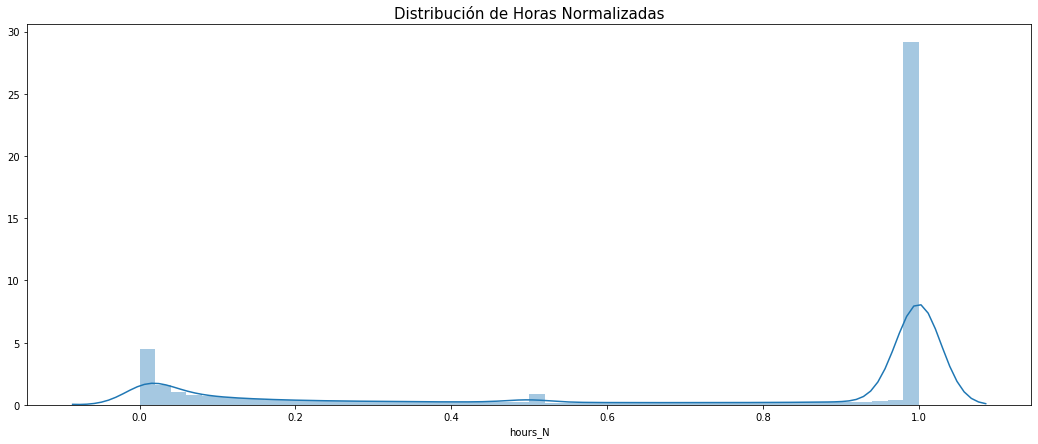

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (18, 7))

plt.title('Distribución de Horas Normalizadas', fontsize = 15)
sns.distplot(rating['hours_N'])

plt.show()


## Ejercicio 2 - Sistema de Recomendación Basado en Usuarios

Este sistema de recomendación deberá entrenar un algoritmo y desarrollar una interfaz que, dado un usuario, le devuelva una lista con los juegos más recomendados.

In [33]:
#reducimos registros en la data original
rating_sample = 5000

games_unicos_dicc = pd.Series(games.app_name.values, index = games.id).to_dict()


In [34]:
#
from collections import defaultdict

from surprise import SVD
from surprise import Dataset
from surprise import Reader


def get_top_n(predictions, n = 10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key = lambda x: x[1], reverse = True)
        top_n[uid] = user_ratings[:n]

    return top_n


# First train an SVD algorithm on the movielens dataset.
#data = Dataset.load_builtin('ml-100k')

reader = Reader(rating_scale = (rating.hours_N.min(), rating.hours_N.max()))
data = Dataset.load_from_df(rating[['user_id', 'product_id', 'hours_N']].sample(rating_sample), reader)

trainset = data.build_full_trainset()
algo = SVD()
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

top_n = get_top_n(predictions, n = 10)


In [35]:
pred = pd.DataFrame(predictions).drop_duplicates(subset = ['uid'])
inv_username_unicos_dicc = {v: k for k, v in username_unicos_dicc.items()}
pred.insert(1, 'u_name', pred.uid.map(inv_username_unicos_dicc))

pred[['uid', 'u_name']].sample(10)


,uid,u_name
8326139,45924,kschang77
1870037,347697,zondes.l
7455230,141560,DpopCharlton
5273512,17740,ussoldier01
85488,26286,NEP-NEP
3024119,69754,starkingdoms.hunter
7610177,236839,hoschi_2003
8329701,505332,Scatah
7961034,637154,sebarndt
3736516,147779,Gho$T® ☃


In [36]:
#Top10 juegos Recomendados para...

USER = 'hoschi_2003'

print('10 juegos Recomendados para: "{}"'.format(USER))
print('-' * (30 + len(USER)))    

for i in top_n.get(username_unicos_dicc.get(USER)):
    try:
        print('-', games_unicos_dicc[i[0]])
    except:
        print('- {}: no lo encuentro en games.'.format(i[0]))
    

10 juegos Recomendados para: "hoschi_2003"
-----------------------------------------
- Garry's Mod
- Super Time Force Ultra
- Paladins®
- Cobi Treasure Deluxe
- Miscreated
- Devilian
- SNOW
- Middle-earth™: Shadow of War™
- Resident Evil 6 / Biohazard 6
- Flight Sim World


## Ejercicio 3 - Sistema de Recomendación Basado en Juegos

Similar al caso anterior, con la diferencia de que este sistema espera como entrada el nombre de un juego y devuelve una lista de juegos similares. El sistema deberá estar programado en base a información de contenido de los juegos (i.e. filtrado basado en contenido o sistema híbrido).

In [37]:
rating_5000 = rating[['user_id', 'product_id', 'hours_N']].sample(5000)
games_5000 = games[games['id'].isin(rating_5000.product_id.unique().tolist())]

games_5000[['app_name', 'id']].sample(10)


,app_name,id
25322,Crusaders of the Lost Idols,402840
22945,BlackShot: Mercenary Warfare FPS,433350
16587,Business Tour - Online Multiplayer Board Game,397900
1736,World Basketball Tycoon,260510
29517,Jazzpunk: Director's Cut,250260
1341,Cubemen 2,228440
2982,METAL GEAR SOLID V: GROUND ZEROES,311340
14855,Brawlhalla,291550
3379,DEAD OR ALIVE 5 Last Round: Core Fighters,311730
584,The Sims™ 3,47890


In [38]:
#
#import io  # needed because of weird encoding of u.item file
from surprise import KNNBaseline
from surprise import get_dataset_dir

def read_item_names():
    """Read the u.item file from MovieLens 100-k dataset and return two
    mappings to convert raw ids into movie names and movie names into raw ids.
    """
    
    rid_to_name = {}
    name_to_rid = {}
    
    for index, line in games_5000.iterrows():
        rid_to_name[line['id']] = line['app_name']
        name_to_rid[line['app_name']] = line['id']

    return rid_to_name, name_to_rid

def dame_top10(game_name, k = 10):
    reader = Reader(rating_scale = (rating_5000.hours_N.min(), rating_5000.hours_N.max()))
    data = Dataset.load_from_df(rating_5000[['user_id', 'product_id', 'hours_N']], reader)

    trainset = data.build_full_trainset()
    sim_options = {'name': 'pearson_baseline', 'user_based': False}
    algo = KNNBaseline(sim_options = sim_options)
    algo.fit(trainset)

    # Read the mappings raw id <-> movie name
    rid_to_name, name_to_rid = read_item_names()

    
    # Retrieve inner id of the movie Toy Story
    game_raw_id = name_to_rid[game_name]
    game_inner_id = algo.trainset.to_inner_iid(game_raw_id)


    # Retrieve inner ids of the nearest neighbors of Toy Story.
    game_neighbors = algo.get_neighbors(game_inner_id, k = 10)
    
    # Convert inner ids of the neighbors into names.
    game_neighbors = (algo.trainset.to_raw_iid(inner_id)
                           for inner_id in game_neighbors)
    game_neighbors = (rid_to_name[rid]
                           for rid in game_neighbors)

    print()
    print('10 juegos Similares a: "{}"'.format(game_name))
    print('-' * (25 + len(game_name)))    
    for games in game_neighbors:
        print('-', games)  


In [45]:
##Top10 juegos similares a...

dame_top10('Cubemen 2')


Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.

10 juegos Similares a: "Cubemen 2"
----------------------------------
- Alan Wake
- Life is Strange - Episode 1
- Paladins®
- Awesomenauts - the 2D moba
- Roundabout
- AdVenture Capitalist
- Company of Heroes 2
- Team Fortress 2
- F.E.A.R. 3
- Duelyst


### Intentamos otra alternativa de recomendar por contenido...

In [40]:
#
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(games_XL, games_XL)

games_idx = dict(zip(games['app_name'], list(games.index)))


In [41]:
#

def get_recommendations(title, n_reco, cosine_sim = cosine_sim):

    idx = games_idx[title]
  
    # Sort the movies based on the similarity scores
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    
    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:(n_reco + 1)]
    
    # Get the movie indices
    games_indices = [i[0] for i in sim_scores]
    
    print()
    print('{} juegos Similares a: "{}"'.format(n_reco, title))
    print('-' * (25 + len(title)))
    print()
    print(games['app_name'].iloc[games_indices])

    return


In [43]:
#hacemos n recomendaciones por título...

get_recommendations('Primal Carnage - Dinosaur Skin Pack 3', 10)



10 juegos Similares a: "Primal Carnage - Dinosaur Skin Pack 3"
--------------------------------------------------------------

21095                                 Shadow Warrior 2
30044                                    Saints Row IV
29805                   Saints Row IV - Thank You Pack
30043                       Saints Row IV: Season Pass
29711    Saints Row IV - How the Saints Save Christmas
29921            Saints Row IV -  Enter The Dominatrix
29630                       Saints Row IV - Anime Pack
29754      Saints Row IV - Element of Destruction Pack
30019                       Saints Row IV - GAT V Pack
29933           Saints Row IV: Commander-In-Chief Pack
Name: app_name, dtype: object


In [92]:
games_idx

{'Lost Summoner Kitty': 0,
 'Ironbound': 1,
 'Real Pool 3D - Poolians': 2,
 '弹炸人2222': 3,
 'Log Challenge': 4,
 'Battle Royale Trainer': 5,
 'SNOW - All Access Basic Pass': 6,
 'SNOW - All Access Pro Pass': 7,
 'SNOW - All Access Legend Pass': 8,
 'Race': 9,
 'Uncanny Islands': 10,
 'Icarus Six Sixty Six': 11,
 'Army of Tentacles: (Not) A Cthulhu Dating Sim: Black GOAT of the Woods Edition': 12,
 'Beach Rules': 13,
 'Planetarium 2 - Zen Odyssey': 14,
 'The first thrust of God': 15,
 'SNOW - Starter Pack': 16,
 'The first thrust of God - All Aircrafts': 17,
 'SNOW - Lifetime Pack': 18,
 'After Life VR': 19,
 'Kitty Hawk': 20,
 'The Warrior Of Treasures': 21,
 'Mortars VR': 22,
 'RC Plane 3 - Canyon Scenario': 23,
 'RC Plane 3 - F-53B': 24,
 'DinoBlaster': 25,
 'Robotpencil Presents: Understanding 3D for Concept': 26,
 'Carmageddon Max Pack': 27,
 'Half-Life': 28,
 'Fallen Mage': 29,
 "Don't Get Hit In The Face": 30,
 'Lost Cities': 31,
 'Twisted Enhanced Edition': 32,
 'Vaporwave Simula